# Exploratory Data Analysis - NYC Taxt Trip Duration


Kaggle Competation Link: https://www.kaggle.com/c/nyc-taxi-trip-duration/

## 1. Problem Statement:

In this competition, our challenge is to build a model that predicts the total ride duration of taxi trips in New York City.

### 1.1 Python Libraries

In [110]:
# #Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import pandas_profiling

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime

import missingno as msno

### 1.2 Datasets

In [5]:
# #Datasets
!ls input/

sample_submission.csv test.csv              train.csv


In [15]:
# #Train and Test Datasets
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

df_sample_submission = pd.read_csv("input/sample_submission.csv")

### 1.3 Data Dictionary

Dataset: input/train.csv

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

### 1.4 Dataset Overview

#### Training Dataset

In [58]:
print "Total number of samples in train dataset: ", df_train.shape[0]
print "Number of columns in train dataset: ", df_train.shape[1]

Total number of samples in train dataset:  1458644
Number of columns in train dataset:  11


In [8]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


#### Test Dataset

In [59]:
print "Total number of samples in test dataset: ", df_test.shape[0]
print "Number of columns in test dataset: ", df_test.shape[1]

Total number of samples in test dataset:  625134
Number of columns in test dataset:  9


In [14]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


#### Sample Submission Dataset

In [16]:
df_sample_submission.shape

(625134, 2)

In [17]:
df_sample_submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


### 1.5 Open-Questions/Hypothesis:


dropoff datetime > pickup datetime ?? anywhere in the train and test datasets
3. Distribution of the dropoff_datetime - pickup_datetime

4. Distribution of the (dropoff_datetime - pickup_datetime)/passenger_count


7. trip_duration - min, max etc - 5 point summary

8. Add the test dataset and the sample submission in the data dictionary as well.

#### 1. Difference in the columns between the training and test datasets:
The training dataset contains 11 columns and the test dataset contains 9 columns. The two additional columns that are present in the training dataset, and not in the test dataset are dropoff_datetime and trip_duration. By looking at the sample_submission.csv file, we understand that we need to predict the trip_duration.

#### 2. Are all the id's in the train and test datasets unique? Is there an overlap, in the observations, between the train and test datasets?

In [76]:
print "Number of ids in the train dataset: ", len(df_train["id"])
print "Number of unique ids in the train dataset: ", len(pd.unique(df_train["id"])), "\n"

print "Number of ids in the test dataset: ", len(df_test["id"])
print "Number of unique ids in the test dataset: ", len(pd.unique(df_test["id"])), "\n"

print "Number of common ids(if any) between the train and test datasets: ", \
len(set(df_train["id"].values).intersection(set(df_test["id"].values)))

Number of ids in the train dataset:  1458644
Number of unique ids in the train dataset:  1458644 

Number of ids in the test dataset:  625134
Number of unique ids in the test dataset:  625134 

Number of common ids(if any) between the train and test datasets:  0


#### 3. Are all the vendor_id's in the train and test datasets unique? 

* vendor_id takes on only two values in both the train and test datasets i.e. 1 and 2 (Hypothesis - This could represent data from two different taxi companies)

#### This leads to a set of follow-up questions:

* If the hypothesis is right and the values in the vendor_id column actually represent the data from two different taxi companies; are the number of observations in the dataset from each of the companies comparable or is there any imbalance?(Both in the train and test datasets)

* Among the vendor_id's(1 and 2) - what is the distribution in the number of passengers (passenger_count) across the train and test datasets?

In [101]:
print "Number of vendor_ids in the train dataset: ", len(df_train["vendor_id"])
print "Number of unique vendor_ids in the train dataset: ", len(pd.unique(df_train["vendor_id"])), "\n"

print "Number of vendor_ids in the test dataset: ", len(df_test["vendor_id"])
print "Number of unique vendor_ids in the test dataset: ", len(pd.unique(df_test["vendor_id"])), "\n"

Number of vendor_ids in the train dataset:  1458644
Number of unique vendor_ids in the train dataset:  2 

Number of vendor_ids in the test dataset:  625134
Number of unique vendor_ids in the test dataset:  2 



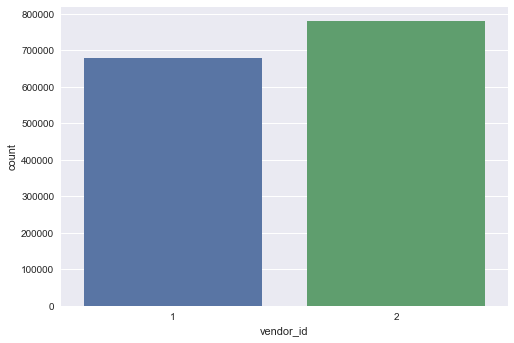

In [79]:
# #The number of observations in the dataset from each of the two companies i.e. 1 and 2, seems to be comparable
# #across the train and test datasets
sns.countplot(x="vendor_id", data=df_train)

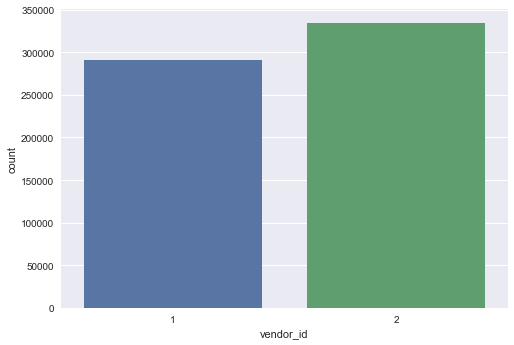

In [84]:
sns.countplot(x="vendor_id", data=df_test)

#### Distribution of the number of passengers (passenger_count) across the vendor_id variables - 1 and 2, in both the train and test datasets

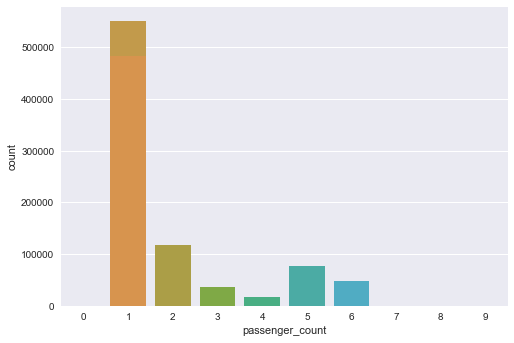

In [102]:
sns.countplot(x="passenger_count", data=df_train[df_train["vendor_id"] == 1])

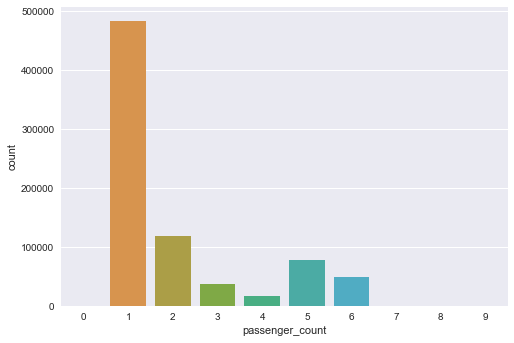

In [97]:
sns.countplot(x="passenger_count", data=df_train[df_train["vendor_id"] == 2])

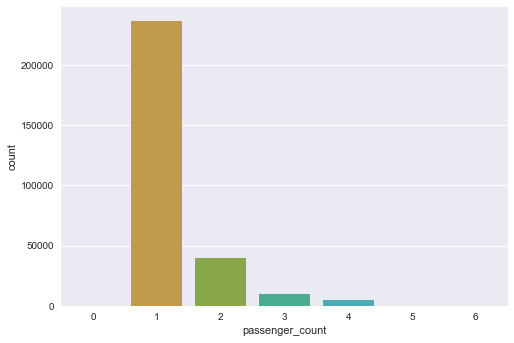

In [103]:
sns.countplot(x="passenger_count", data=df_test[df_test["vendor_id"] == 1])

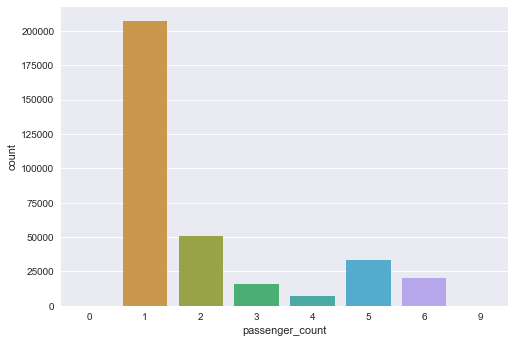

In [104]:
sns.countplot(x="passenger_count", data=df_test[df_test["vendor_id"] == 2])

#### 4. Distribution of the trip_duration across the train dataset 

In [114]:
# #String to Datetime conversion
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"])
df_train["dropoff_datetime"] = pd.to_datetime(df_train["dropoff_datetime"])

df_test["pickup_datetime"] = pd.to_datetime(df_test["pickup_datetime"])

In [142]:
# #trip_duration represents the difference between the dropoff_datetime and the pickup_datetime in the
# #train dataset
df_train["trip_duration"].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [143]:
# #The trip_duration would be a lot more intuitive when the datetime representation is used, 
# #rather than the representation with seconds. 
(df_train["dropoff_datetime"] - df_train["pickup_datetime"]).describe()

count                   1458644
mean     0 days 00:15:59.492272
std      0 days 01:27:17.431724
min             0 days 00:00:01
25%             0 days 00:06:37
50%             0 days 00:11:02
75%             0 days 00:17:55
max            40 days 19:31:22
dtype: object

_It is interesting to see that there happens to be a trip that lasted for over 40 days. Let us plot the trip duration in seconds to view any other possbile outliers._

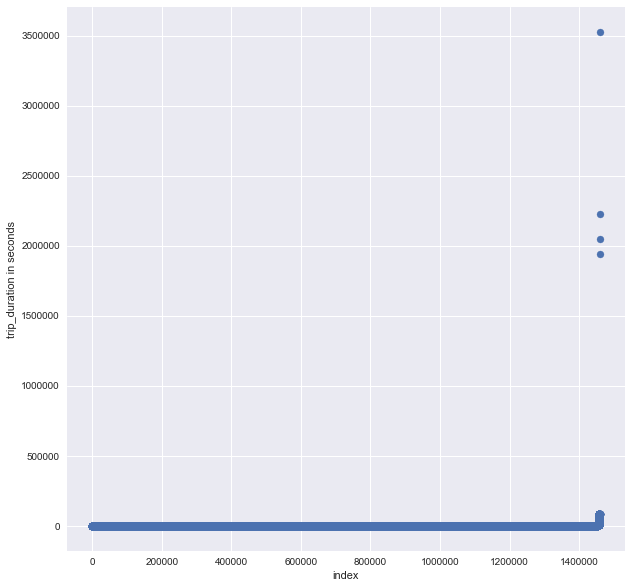

In [168]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(df_train["trip_duration"])), np.sort(df_train["trip_duration"]))
plt.xlabel('index')
plt.ylabel('trip_duration in seconds')
plt.show()

_We see that there are four outliers with trip durations of 20 days or more_

In [174]:
# #Removing the outliers in the dataset
df_train = df_train[df_train["trip_duration"] < 500000]

In [175]:
(df_train["dropoff_datetime"] - df_train["pickup_datetime"]).describe()

count                   1458640
mean     0 days 00:15:52.815251
std      0 days 00:52:51.322283
min             0 days 00:00:01
25%             0 days 00:06:37
50%             0 days 00:11:02
75%             0 days 00:17:55
max             0 days 23:59:52
dtype: object

In [185]:
(np.sort(df_train["trip_duration"])[-20:])

array([86364, 86364, 86365, 86366, 86367, 86367, 86369, 86369, 86369,
       86369, 86377, 86377, 86378, 86378, 86379, 86385, 86387, 86390,
       86391, 86392])

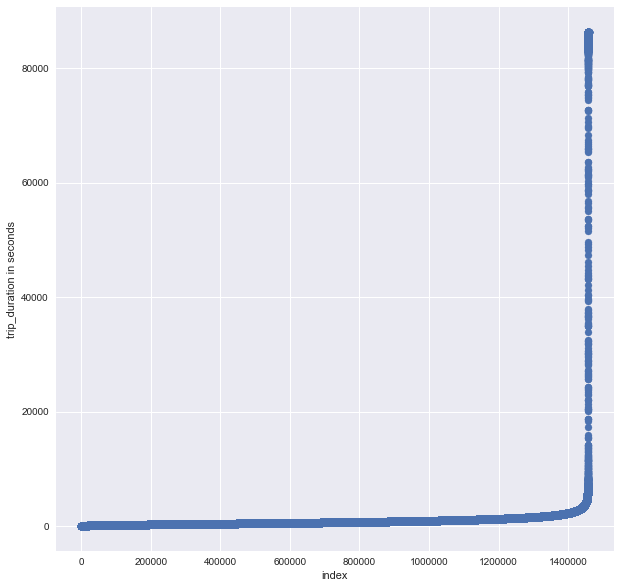

In [180]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(df_train["trip_duration"])), np.sort(df_train["trip_duration"]))
plt.xlabel('index')
plt.ylabel('trip_duration in seconds')
plt.show()

In [179]:
df_train.groupby(pd.TimeGrouper(freq='60Min')).count().plot(kind='bar')

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'